### LITTLE EYES V3
#### Meu Terceiro Modelo de Visão Computacional

Validação cruzada / controle de parada para selecionar o modelo mais genérico 

In [1]:
# NETWORK
the_seed = 32
digit_size = (28, 28, 1)
convnn_activation = 'relu'
fully_connected_activation = 'tanh'
hyperparameter_max = 5
learning_rate = 0.01
max_epochs = 5
score_metric = 'accuracy'
verbose = 1

# VALIDATION
n_folds = 5

In [2]:
import tensorflow
from tensorflow.keras import datasets, models, layers, optimizers, Input, Model
from matplotlib import pyplot
import numpy
import pandas
import random
from sklearn.model_selection import StratifiedKFold
from seaborn import boxplot
from sklearn.metrics import accuracy_score

In [3]:
random.seed(the_seed)
numpy.random.seed(the_seed)
tensorflow.random.set_seed(the_seed)

In [4]:
def create_little_eyes(digit_size : tuple[int, int, int] = (28, 28, 1),
                       convnn_activation : str = 'relu',
                       fully_connected_activation : str = 'tanh',
                       net_name : str = 'LittleEyes',
                       hyperparameter : int = 1):
    # CAMADA DE ENTRADA
    inputs = Input(shape=digit_size)

    # PRIMEIRA CAMADA CONVOLUCIONAL
    conv_2d_layer_1 = layers.Conv2D(2*hyperparameter, (3, 3), activation=convnn_activation)
    x = conv_2d_layer_1(inputs)

    # PRIMEIRA CAMADA MAX POOLING
    maxpool_1 = layers.MaxPooling2D((2, 2))
    x = maxpool_1(x)

    # SEGUNDA CAMADA CONVOLUCIONAL
    conv_2d_layer_2 = layers.Conv2D(4*hyperparameter, (3, 3), activation=convnn_activation)
    x = conv_2d_layer_2(x)

    # SEGUNDA CAMADA MAX POOLING
    maxpool_2 = layers.MaxPooling2D((2, 2))
    x = maxpool_2(x)

    # TERCEIRA CAMADA CONVOLUCIONAL
    conv_2d_layer_3 = layers.Conv2D(4*hyperparameter, (3, 3), activation=convnn_activation)
    x = conv_2d_layer_3(x)

    # TERCEIRA CAMADA MAX POOLING
    maxpool_3 = layers.MaxPooling2D((2, 2))
    x = maxpool_3(x)

    # FLATTEN
    flatten_layer = layers.Flatten()
    x = flatten_layer(x)

    # FULLY CONNECTED HIDDEN LAYER
    hidden_layer = layers.Dense(hyperparameter + 1, activation=fully_connected_activation)
    x = hidden_layer(x)

    # OUTPUT LAYER
    output_layer = layers.Dense(10)
    outputs = output_layer(x)

    return Model(inputs=inputs, outputs=outputs, name=net_name)

In [5]:
(train_images, train_labels), (validation_images, validation_labels) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, validation_images = train_images / 255.0, validation_images / 255.0

In [6]:
train_images.shape, validation_images.shape

((60000, 28, 28), (10000, 28, 28))

In [7]:
numpy.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

In [8]:
result_list = []
kfolder = StratifiedKFold(n_splits=n_folds, random_state=the_seed, shuffle=True)
for hyperparameter in numpy.arange(1, hyperparameter_max+1):
    for i, (train_index, validation_index) in enumerate(kfolder.split(train_images, train_labels)):
        X_train, Y_train = train_images[train_index], train_labels[train_index]
        X_val, Y_val = train_images[validation_index], train_labels[validation_index]

        # NET NAME > Hyperparameter + Fold Number
        net_name = f"LittleEyes_{hyperparameter}_{i}"
        print(f"{net_name} training started...")
        little_eyes = create_little_eyes(net_name = net_name,
                                        hyperparameter=hyperparameter)
        opt = optimizers.Adam(learning_rate=learning_rate)
        little_eyes.compile(optimizer=opt,
                    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[score_metric])

        history = little_eyes.fit(X_train, Y_train, epochs=max_epochs, 
                                validation_data=(X_val, Y_val),
                                verbose=verbose)

        training_score = history.history[score_metric][-1]
        validation_score = history.history[f"val_{score_metric}"][-1]
        result_list.append((net_name, hyperparameter, i, training_score, validation_score, little_eyes))
        print(f"{net_name.upper()}: {100*training_score:.0f}% TRAINING {score_metric.upper()} / {100*validation_score:.0f}% VALIDATION {score_metric.upper()}")
        

LittleEyes_1_0 training started...


Epoch 1/5


1500/1500 [==============================] - 7s 4ms/step - loss: 1.3781 - accuracy: 0.4451 - val_loss: 1.1881 - val_accuracy: 0.5591
Epoch 2/5
1500/1500 [==============================] - 5s 3ms/step - loss: 1.1096 - accuracy: 0.6003 - val_loss: 1.0600 - val_accuracy: 0.6389
Epoch 3/5
1500/1500 [==============================] - 5s 4ms/step - loss: 0.9947 - accuracy: 0.6492 - val_loss: 1.0292 - val_accuracy: 0.6127
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.9491 - accuracy: 0.6740 - val_loss: 0.9242 - val_accuracy: 0.6915
Epoch 5/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.9130 - accuracy: 0.6865 - val_loss: 0.9390 - val_accuracy: 0.6787
LITTLEEYES_1_0: 69% TRAINING ACCURACY / 68% VALIDATION ACCURACY
LittleEyes_1_1 training started...
Epoch 1/5
1500/1500 [==============================] - 7s 4ms/step - loss: 1.5475 - accuracy: 0.3839 - val_loss: 1.1773 - val_accuracy: 0.5521
Epoc

In [9]:
results = pandas.DataFrame.from_records(result_list)
results.columns = ["net_name", "hyperparameter", "kfold", score_metric, f"val_{score_metric}", "little_eyes"]
results.sort_values("val_accuracy", ascending=False)

,net_name,hyperparameter,kfold,accuracy,val_accuracy,little_eyes
24,LittleEyes_5_4,5,4,0.954229,0.957250,<keras.src.engine.functional.Functional object...
15,LittleEyes_4_0,4,0,0.951792,0.951333,<keras.src.engine.functional.Functional object...
17,LittleEyes_4_2,4,2,0.952500,0.950917,<keras.src.engine.functional.Functional object...
18,LittleEyes_4_3,4,3,0.950854,0.949000,<keras.src.engine.functional.Functional object...
16,LittleEyes_4_1,4,1,0.952479,0.948667,<keras.src.engine.functional.Functional object...
19,LittleEyes_4_4,4,4,0.944625,0.947750,<keras.src.engine.functional.Functional object...
21,LittleEyes_5_1,5,1,0.949375,0.947667,<keras.src.engine.functional.Functional object...
11,LittleEyes_3_1,3,1,0.938896,0.946417,<keras.src.engine.functional.Functional object...
12,LittleEyes_3_2,3,2,0.943021,0.945833,<keras.src.engine.functional.Functional object...
22,LittleEyes_5_2,5,2,0.950813,0.945083,<keras.src.engine.functional.Functional object...


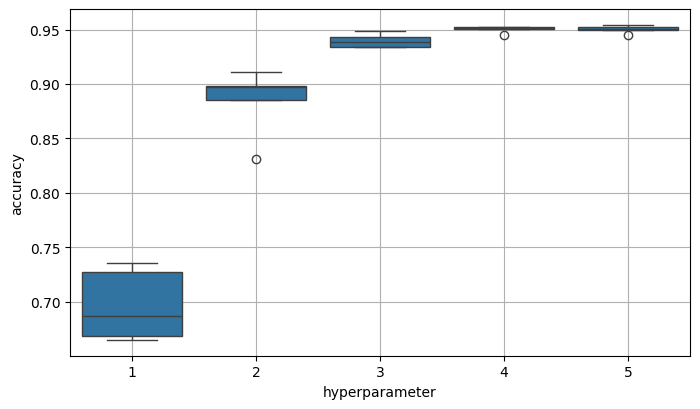

In [10]:
fig = pyplot.figure(figsize=(8, 4.5))
ax = fig.add_subplot(111)
boxplot(results, x="hyperparameter", y="accuracy", ax=ax)
ax.grid()

In [11]:
little_eyes = results.sort_values('val_accuracy', ascending=False).head(1)['little_eyes'].values[0]
little_eyes

In [12]:
Y_test = little_eyes.predict(validation_images)

313/313 [==============================] - 1s 2ms/step


In [13]:
Y_predicted = numpy.argmax(Y_test, axis=1)
Y_predicted

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [37]:
misclassifications = validation_labels != Y_predicted
misclassified_indices = numpy.where(misclassifications)[0]
misclassified_labels = validation_labels[misclassified_indices]
misclassified_predictions = Y_predicted[misclassified_indices]

misclassified_indices[:10]

array([  8,  41,  43,  73, 114, 144, 175, 255, 282, 287], dtype=int64)

TRUE NUMBER 7 >> PREDICTED NUMBER 2


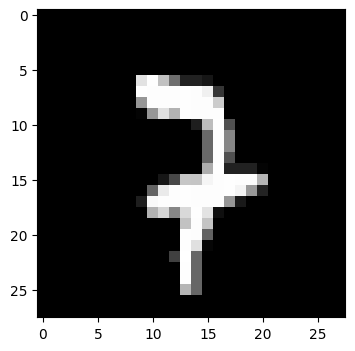

In [46]:
# TABAJARA VALIDATOR
image_id = 114
print(f"TRUE NUMBER {validation_labels[image_id]} >> PREDICTED NUMBER {Y_predicted[image_id]}")
# Y_test[image_id, :]
fig = pyplot.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
_ = pyplot.imshow(validation_images[image_id], cmap="Greys_r")